[View in Colaboratory](https://colab.research.google.com/github/paulanavarretec/RecSys-Tarea1/blob/master/Recsys_Tarea1.ipynb)

# Recommender Algorithms for a Beer Selling platform


---



In this asisgnment we developed several Recommender algorithms and test their performance. We used pyreclab Python library, developed by IALab & SocVis from the Pontifical Catholic University of Chile.

The algorithms to be perfomed ahead are:

- UserKnn

- ItemKnn

- SlopeOne

- SVD

- ALS o ALScg: (este modelo lo puede usar para la tarea de ranking. Si tiene problemas con pyreclab, puede usar la biblioteca implicit1).

# Data Load and Exploration

First step is to download to local computer the relevant files through the following links:

(update links
- Train file: https://drive.google.com/file/d/1Anro2DyEgN0sUHXFyxVe2qoSya6hzQSp/view?usp=sharing

- Test File: https://drive.google.com/file/d/1Awy3QKCdkSpNeRXATqRBUMi56M47Ia0n/view?usp=sharing

- Ranking File: https://drive.google.com/file/d/1B7QhEodQ13QlOHOTp9zaa52exlfgAOl3/view?usp=sharing

And then upload them.

In [1]:
#Run this cell if working con Colab. You must upload the files to be used in the analysis: training_data.csv, test_rating_data.csv y ranking_users.txt
from google.colab import files
uploaded = files.upload()

Saving ranking_users.txt to ranking_users.txt
Saving test_rating_data.csv to test_rating_data.csv
Saving training_data.csv to training_data.csv


*training_data.csv* and *test_data.csv* files have tuples of the form {'obsNo', 'userID',  'itemID',  'styleID', 'rating', 'brewerID', 'timestamp'} wich is the information of user preferences among the diferent beer features.

Let's load the files into pandas data structure to be handled:

In [0]:
#Import library
import pandas as pd

#Read both train and test files into separate data structures
train_file = pd.read_csv('training_data.csv',
                         sep=',',
                         names = ['obsNo','userID', 'itemID', 'styleID', 'rating','brewerID','timestamp'],
                         header=0)

test_file = pd.read_csv('test_rating_data.csv',                    
                         sep=',',
                         names = ['obsNo','itemID',  'styleID',  'userID',  'brewerID',   'timestamp'],
                         header=0)

### Looking at the numbers 

The head and tail of the training_data.csv can be visualized as follows, among with the other columns.

In [3]:
print(train_file.head())
print(train_file.tail(),'\n\n')

   obsNo  userID  itemID  styleID  rating  brewerID   timestamp
0      0    4924   11757       84     4.5      1199  1247372118
1      1    4924    5441        2     4.5      1199  1209176445
2      2    4924   19960       84     5.0      1199  1223914717
3      3    2916   55900       80     2.5      1199  1291336093
4      4    2916   57110       73     4.0     14879  1279318326
       obsNo  userID  itemID  styleID  rating  brewerID   timestamp
44347  44374    3230   11757       84     5.0      1199  1286494547
44348  44375    4630   11757       84     2.5      1199  1254948632
44349  44376    6118   20470       64     4.0       394  1204330634
44350  44377    6118    1324       59     3.5       263  1212967655
44351  44378    7268    1504       13     5.0       568  1157647130 




As we can see, users and items are represented by an integer, style and brewer too, rating is represented with a decimal  numer and they all range in a wide spectrum. But we need a little bit more information to see if we have enough users and/or items to be able to predict something.

Let's get some stats out of the sample. The following code gets the total number of unique instances for each column, i.e. how many different users,  items, styles, rating, brewerID and timestamps there are:

In [5]:
print(train_file.nunique())

obsNo        44352
userID        8318
itemID        1836
styleID         95
rating          10
brewerID       210
timestamp    43905
dtype: int64


This is nice because we have a large sample, compounded by many (but a lot less) items and users and we have more users than items (as spected). We have ten different decimal ratings (we guess 0 to 10 incremented by 0.5). We have a lot less different styles and brewers.

### Summary statistics

Now, let's take a deeper look into de shape of the data, to do that, we use different statistic functions provided by pandas library. 
It is important to notice that the overall mean rating is 3.8 and the lowest 25% of the ratings are below 3.5 and the highest 25% of the ratings are above 4.5.

In [6]:
# print('Summary\n\n',train_file.describe(),'\n')
# get description of the rating attribute
train_file['rating'].describe()

count    44352.000000
mean         3.864910
std          0.712695
min          0.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: rating, dtype: float64

In [7]:
# print('Variance:\n',train_file.var(),'\n')    # Sample variance of rating values
train_file['rating'].var()

0.5079335267039778

In [8]:
# print('Standard deviation:\n',train_file.std(),'\n')     # Sample standard deviation of rating values
train_file['rating'].std()

0.7126945535809698

Skewness is a measure for symmetry, and encompases the lack of it. Any symmetric data should have a skewness near zero: negative values indicate data that are skewed left and positive values for the skewness indicate data that are skewed right. By skewed left, we mean that the left tail is long relative to the right tail and the skewness of our data refects this.

In [9]:
# Get Skewness of rating values
# print('Skew:\n',train_file.skew(),'\n')    
train_file['rating'].skew()

-1.0136247168640184

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution wich has a kurtosis of zero. Data sets with high kurtosis (positive values) tend to have heavy tails, or outliers and data sets with low kurtosis (negative valueas) tend to have light tails, or lack of outliers. 

In [10]:
# print('Kurtosis:\n',train_file.kurt(),'\n')    # Kurtosis of rating values
train_file['rating'].kurt()

1.6312861143143267

All characteristics mentioned can also be seen in the folowing figure. We can appreciate the ratings are biased towards the 4.0, and they tend to accumulate around 

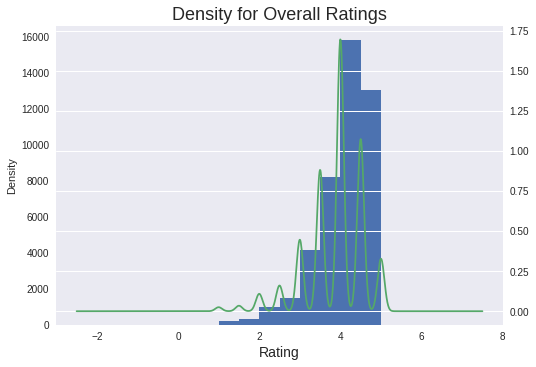

In [11]:
# Rating density plot

ax = train_file.rating.plot(kind='hist')
ax.set_title('Density for Overall Ratings', fontsize=18)
ax.set_xlabel('Rating', fontsize=14)

train_file.rating.plot(kind='kde', ax=ax, secondary_y=True)

## Dataset Density

Now, let's see all these tendencies we've resumed in the numbers just examined. First I plot the density function of the user rankings. The following plot depicts the frecuency for the y-axis of reviews per user and a probability density function.

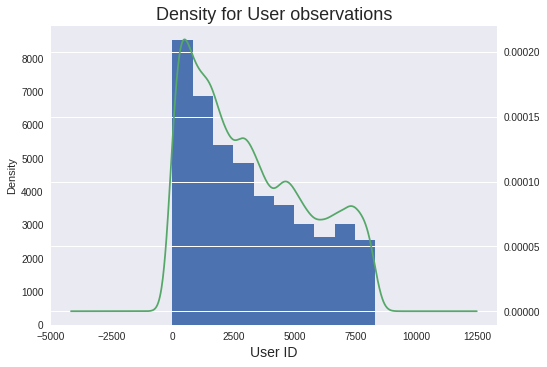

In [12]:
# train_file['userID'].plot.kde() 
# train_file['userID'].plot.hist() # or alternatively

ax = train_file.userID.plot(kind='hist')
ax.set_title('Density for User observations', fontsize=18)
ax.set_xlabel('User ID', fontsize=14)

train_file.userID.plot(kind='kde', ax=ax, secondary_y=True)

We can take a chek skewness and kurtosis and confirm bigger right tail and lack of outliers.

In [14]:
# Get Skewness of rating values 
print('Skewness: ',train_file['userID'].skew())
print('Kurtosis: ',train_file['userID'].kurt())

Skewness:  0.4976564576757495
Kurtosis:  -0.9416296240560209


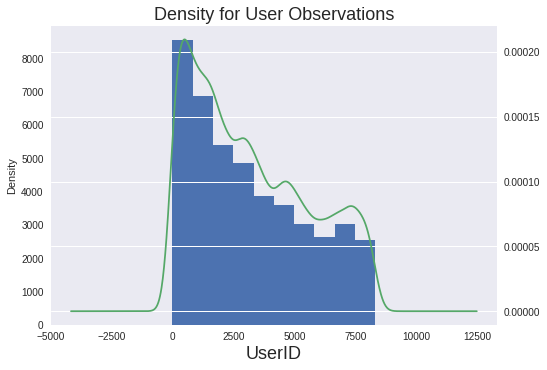

In [16]:
# train_file['userID'].plot.kde() 
# train_file['userID'].plot.hist() # or alternatively

ax = train_file.userID.plot(kind='hist')
ax.set_title('Density for User Observations', fontsize=18)
ax.set_xlabel('UserID', fontsize=14)
train_file.userID.plot(kind='kde', ax=ax, secondary_y=True)


The shape is congruent with the tendency to have less users in the beginnig (the so*-called* early adopters) giving lots of ratings and helping the system to learn, and afterwads, a lot of new users giving a lot of less reviews. 

The same can be chequed out analogously for the items.

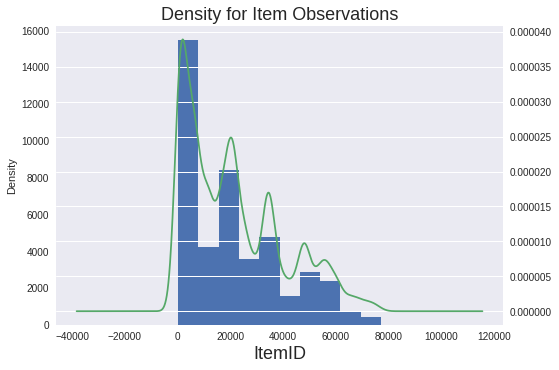

In [13]:
ax = train_file.itemID.plot(kind='hist')

ax.set_title('Density for Item Observations', fontsize=18)
ax.set_xlabel('ItemID', fontsize=14)
train_file.itemID.plot(kind='kde', ax=ax, secondary_y=True)

It is interesting what this plot shows. We can see a sort of different waves, characterized by a peak of ratings for some items, but a comparable bigger tail of items rated comparatively less. This may suggest that new items were introduced in 4 to 5 waves along time, where we initial introductions brought several more reviews per item introduced than the later, making sense with the previous analysis of users.

## Dataset Distribution



### user/item Distribution

we created a new dataframe containing number of ratings per user.

In [14]:
# Group the matrix by userID, call its frecuency as userRatings and
# sort it in a descendig order for user ratings.
# print its first and last values

df=(train_file.groupby(['userID']).size().reset_index(name='userRatings')).sort_values('userRatings', ascending=False)
print(df.head())
(df.tail())

     userID  userRatings
12       13          181
23       24          129
489     490          115
99      100          111
694     695          106


,userID,userRatings
5503,5505,1
2611,2612,1
2608,2609,1
2606,2607,1
8317,8320,1


In [15]:
# Get Summary statistics
df.describe()

,userID,userRatings
count,8318.000000,8318.000000
mean,4159.914883,5.332051
std,2401.778933,9.921520
min,1.000000,1.000000
25%,2080.250000,1.000000
50%,4159.500000,2.000000
75%,6239.750000,5.000000
max,8320.000000,181.000000


In [16]:

# Get Skewness and kurtosis for ratings per user frecuency
print('Skewness: ',df['userRatings'].skew())
print('Kurtosis: ',df['userRatings'].kurt())

Skewness:  5.023945526673108
Kurtosis:  38.68445514758519


The positive value for the skewness indicates that the right tail is bigger than the left, wich is consistent with our previous knowledge that there should be many users rating few items and much more less rating a lot. The kustosis high value is also consistent with this, showing the presence of outliers (users at the top of table). This can be clearly seen in the distribution figure below.

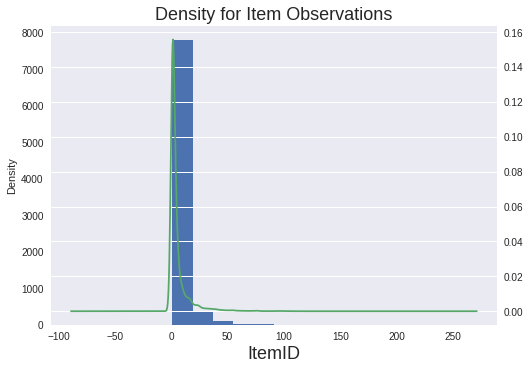

In [17]:
ax = df.userRatings.plot(kind='hist')

ax.set_title('Density for Item Observations', fontsize=18)
ax.set_xlabel('ItemID', fontsize=14)
df.userRatings.plot(kind='kde', ax=ax, secondary_y=True)

Now, we can explore how the distribution of number ratings per user behaves

In [74]:
df = train_file.groupby(['userID']).size().reset_index(name='userRatings').sort_values('userRatings', ascending=False)

df = df.groupby('userRatings').count().reset_index()
df.columns=['userRatings','count']

# Check to see that it sums up the total number of users
print(df['count'].sum())

print(df.head())
print(df.tail())

# Get Description, Skewness and kurtosis for ratings per user frecuency
print('Skewness: ',df['userRatings'].skew())
print('Kurtosis: ',df['userRatings'].kurt())

8318
   userRatings  count
0            1   3918
1            2    992
2            3    584
3            4    600
4            5    434
    userRatings  count
84          106      1
85          111      1
86          115      1
87          129      1
88          181      1
Skewness:  0.9624353670943612
Kurtosis:  1.6752496252076026


The positive value for the skewness indicates that the right tail is bigger than the left, wich is consistent with our previous knowledge that there should be few users rating a lot of items and much more rating just a few. The kustosis positive value is also consistent with this, showing the presence of outliers (users at the top of table). This can be clearly seen in the distribution figure below.

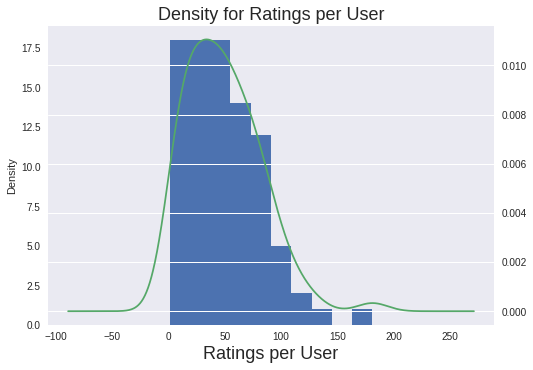

In [72]:
ax = df.userRatings.plot(kind='hist')

ax.set_title('Density for Ratings per User', fontsize=18)
ax.set_xlabel('Ratings per User', fontsize=14)
df.userRatings.plot(kind='kde', ax=ax, secondary_y=True)

### item/user Distribution

Making the same analysis as before for the rated items distribution, we created a new dataframe containing number of ratings per item.

In [18]:
# Group the matrix by itemID, call its frecuency as itemRatings and
# sort it in a descendig order for item ratings.
# print its first and last values

df=(train_file.groupby(['itemID']).size().reset_index(name='itemRatings')).sort_values('itemRatings', ascending=False)
print(df.head())
print(df.tail())


     itemID  itemRatings
244   11757         2205
414   19960         1679
331   16074         1260
118    5441         1252
3       429         1182
      itemID  itemRatings
1137   50083            1
1139   50089            1
1140   50215            1
325    15655            1
1835   77207            1


In [33]:
# Get Summary statistics
df.describe()

,itemID,itemRatings
count,1836.00000,1836.000000
mean,40440.12037,24.156863
std,22286.11968,113.849140
min,175.00000,1.000000
25%,21640.75000,1.000000
50%,41525.50000,2.000000
75%,60511.25000,7.000000
max,77207.00000,2205.000000


In [34]:
# Get Skewness and kurtosis for ratings per user frecuency
print('Skewness: ',df['itemRatings'].skew())
print('Kurtosis: ',df['itemRatings'].kurt())

Skewness:  10.323106248359037
Kurtosis:  136.4605471342013


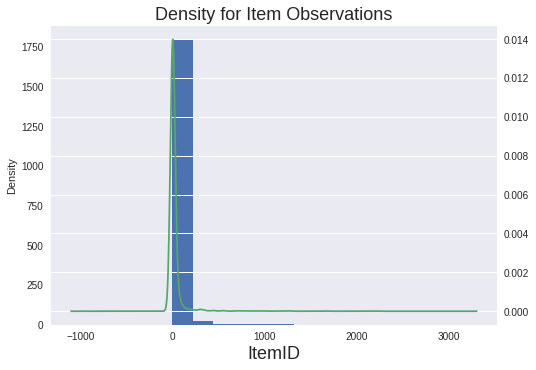

In [35]:
ax = df.itemRatings.plot(kind='hist')

ax.set_title('Density for Item Observations', fontsize=18)
ax.set_xlabel('ItemID', fontsize=14)
df.itemRatings.plot(kind='kde', ax=ax, secondary_y=True)

# Experimentation

In [0]:
# First, some basics for data manipulation
# Example for visualizing observations characteristics based on user IDs

users = [5,4,1,2,3]
train_file.loc[users][['styleID', 'brewerID']]

,styleID,brewerID
5,1199,1199
4,14879,14879
1,1199,1199
2,1199,1199
3,1199,1199


In [0]:
!pip install pyreclab
import pyreclab
import numpy as np

    100% |████████████████████████████████| 153kB 6.3MB/s 


## UserKnn

In [0]:
# Declare UserKnn recommender object 

myUserKnn = pyreclab.UserKnn(dataset='training_data.csv',
                             dlmchar=b',',
                             header=True,
                             usercol=1,
                             itemcol=2,
                             ratingcol=4)

In [0]:
# Entrenamos el modelo con los datos existentes
# Recuerde que se puede probar el parámetro k de cantidad de vecinos
# así como la métrica de similaridad (pearson, cosine)
myUserKnn.train(7, 'pearson')

In [0]:
prediction = myUserKnn.predict( "4924", "57110" )
print(prediction)

4.562244892120361


In [0]:
ranking4 = myUserKnn.recommend( "4924")
print(ranking4)

print("\nUser Knn Reclist para usuario 4924")
items = np.array(ranking4).astype(int)
# print(info_file.loc[items][['title', 'release_date']])

['50524', '12734', '64487', '38766', '64816', '50084', '66849', '6329', '49786', '54995']

User Knn Reclist para usuario 457
